# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [ ]:
# Install Pytorch in the local anaconda environment

!conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
!pip install split-folders


In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import numpy as np
import splitfolders
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

batch_size = 20
valid_ratio = 0.2
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# Path for Training and Test Data
train_dir = "./landmark_images/train/"
test_dir = "./landmark_images/test/"

# Image Transformers
im_transform_train = transforms.Compose([transforms.CenterCrop((256,256)),
                                         transforms.RandomHorizontalFlip(p=0.1),
                                         transforms.RandomChoice([
                                            transforms.ColorJitter(hue=0.1),
                                            transforms.ColorJitter(brightness=0.2),
                                            transforms.ColorJitter(saturation=0.3),
                                            transforms.ColorJitter(contrast=0.3),
                                            ]),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)])

im_transform_test = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])
            

#splitfolders.ratio("./landmark_images/train", output="train_valid", seed=666, ratio=(.8, .2), group_prefix=None)

# Load the image data
train_data = datasets.ImageFolder('./train_valid/train', transform=im_transform_train)
valid_data = datasets.ImageFolder('./train_valid/val', transform=im_transform_test)
test_data = datasets.ImageFolder('./landmark_images/test', transform=im_transform_test)

# Save classes names 
n_classes = len(train_data.classes)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# print out number of training and test samples
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))


Num training images:  3996
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

- Did you decide to augment the dataset?  If so,how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: RESPONSE #1: The code performs center crop with size = 256x256 pixels. This size is stil capable of capturing enough features from the images for a good classification performance, without requiring extensive computational resources to fit the CNN model.
RESPONSE #2: Yes, I have augmented the training data by applying the following filters: random horizontal flip (probability = 10%), random variations in hue (10%) brightness (20%), saturation (30%) and contrast (30%). Ultimately the images (training and test) were normalized to the common factors for mean and std for RGB images. The augmentation aimed to contribute for a better generalization of the CNN model. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

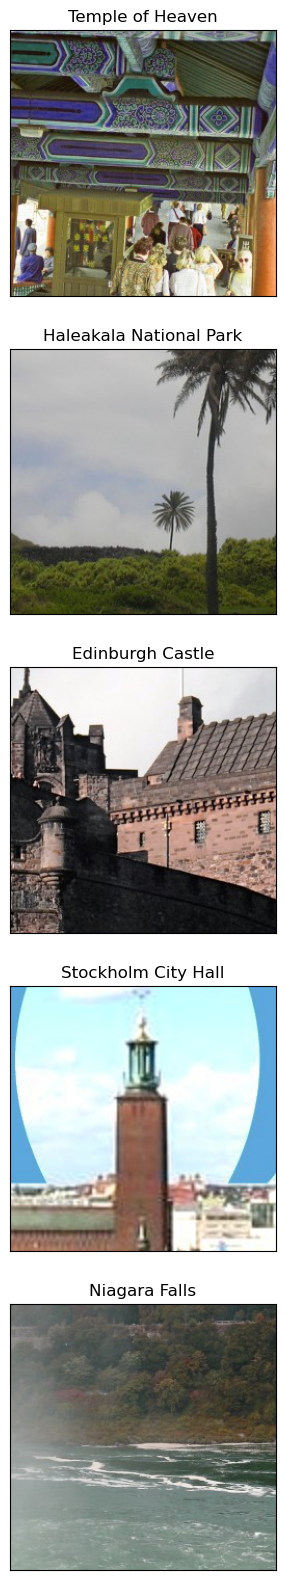

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)


def unnormlize(img, s, m):
    return img * s[:, None, None] + m[:, None, None]

import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

fig = plt.figure(figsize=(20,20))

for idx in range(5):
    ax = fig.add_subplot(5, 1, idx+1, xticks=[], yticks=[])
    rand_img = random.randint(0, len(train_data))
    img = unnormlize(train_data[rand_img][0], torch.Tensor(std), torch.Tensor(mean)) # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # convert from Tensor image
    class_name = classes[train_data[rand_img][1]]
    ax.set_title(class_name)

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function

# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.005)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
# define the CNN architecture
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()           
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # sees 256x256x3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # sees 128x128x16
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # sees 64x64x32
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1) # sees 32x32x64
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 50)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1d = nn.BatchNorm1d(256)
        self.batch_norm2d_1 = nn.BatchNorm2d(32)
        self.batch_norm2d_2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm2d_1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batch_norm2d_2(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.batch_norm1d(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [6]:
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1d): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2d_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2d_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I have tried many diferent architectures before finding the best one that could perform to greater than 20%. I have seen many CNNs in github working with the same dataset using exactly 3 convolutional layers and 2 full connected layers. However, that seemed not to be enough in my case. I have clearly identified improvements on the performance after selecting the following architecture: 2 convolutional layers (total number of features = 32), 2d batch normalization layer, 1 conv. layer (total number of features = 64), 2nd 2d batch normalization layer, 1 conv. layer (total number of features = 128), 1 fully-connected layer (in_features=32768, out_features=256), 1d batch normalization layer, 2nd fully-connected layer (in_features=256, out_features=50). The batch normalization layers and the Dropout layers (placed between the fully-connected layers with p=0.5) were applied as regularization steps to improve performance and mitigate overfitting, respectively.        

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 
       
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [9]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:    
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.760736 	Validation Loss: 3.496189
Validation loss decreased (inf --> 3.496189).  Saving model ...
Epoch: 2 	Training Loss: 3.427378 	Validation Loss: 3.390349
Validation loss decreased (3.496189 --> 3.390349).  Saving model ...
Epoch: 3 	Training Loss: 3.198332 	Validation Loss: 3.326743
Validation loss decreased (3.390349 --> 3.326743).  Saving model ...
Epoch: 4 	Training Loss: 3.019888 	Validation Loss: 3.282923
Validation loss decreased (3.326743 --> 3.282923).  Saving model ...
Epoch: 5 	Training Loss: 2.863702 	Validation Loss: 3.284841
Epoch: 6 	Training Loss: 2.668408 	Validation Loss: 3.206740
Validation loss decreased (3.282923 --> 3.206740).  Saving model ...
Epoch: 7 	Training Loss: 2.464078 	Validation Loss: 3.208158
Epoch: 8 	Training Loss: 2.266503 	Validation Loss: 3.168467
Validation loss decreased (3.206740 --> 3.168467).  Saving model ...
Epoch: 9 	Training Loss: 2.091204 	Validation Loss: 3.214993
Epoch: 10 	Training Loss: 1.932554 	Valida

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [10]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.819360 	Validation Loss: 3.571851
Validation loss decreased (inf --> 3.571851).  Saving model ...
Epoch: 2 	Training Loss: 3.487558 	Validation Loss: 3.429518
Validation loss decreased (3.571851 --> 3.429518).  Saving model ...
Epoch: 3 	Training Loss: 3.273933 	Validation Loss: 3.526866
Epoch: 4 	Training Loss: 3.111177 	Validation Loss: 3.282072
Validation loss decreased (3.429518 --> 3.282072).  Saving model ...
Epoch: 5 	Training Loss: 2.900369 	Validation Loss: 3.285954
Epoch: 6 	Training Loss: 2.735530 	Validation Loss: 3.252147
Validation loss decreased (3.282072 --> 3.252147).  Saving model ...
Epoch: 7 	Training Loss: 2.530772 	Validation Loss: 3.215694
Validation loss decreased (3.252147 --> 3.215694).  Saving model ...
Epoch: 8 	Training Loss: 2.341448 	Validation Loss: 3.234657
Epoch: 9 	Training Loss: 2.185905 	Validation Loss: 3.284437
Epoch: 10 	Training Loss: 1.998224 	Validation Loss: 3.222205
Epoch: 11 	Training Loss: 1.875684 	Validation Lo

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.188584


Test Accuracy: 21% (272/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [12]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size= 20 # how many samples the CNN sees and learn from at a time
valid_size = 0.2

# allow us to iterate data once batch at a time
loaders_transfer = loaders_scratch.copy()




### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [13]:
## TODO: select loss function
# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer
def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.005)
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
## TODO: Specify model architecture
import torch.nn as nn
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

#freezing features- weights
for param in model_transfer.features.parameters():
    param.require_grad =False
    
# replace last layer    
model_transfer.classifier[6] = nn.Linear(model_transfer.classifier[6].in_features, len(train_data.classes))

print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

C:\Users\G.Lionello-Alexan2-B\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\G.Lionello-Alexan2-B\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ For the Transfer Learning step, I have used the VGG16 CNN and adjusted the last fully-connected layer to provide 50 outputs that are the final class predictions of this dataset. The intent is to take advantage of the built architecture and optimized weights from this efficient CNN for image classification and be able to predict the landmark images with performance greater than 60%.   

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 20

# train the model
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')



#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.438000 	Validation Loss: 1.443755
Validation loss decreased (inf --> 1.443755).  Saving model ...
Epoch: 2 	Training Loss: 1.390213 	Validation Loss: 1.298092
Validation loss decreased (1.443755 --> 1.298092).  Saving model ...
Epoch: 3 	Training Loss: 1.018841 	Validation Loss: 1.238036
Validation loss decreased (1.298092 --> 1.238036).  Saving model ...
Epoch: 4 	Training Loss: 0.814642 	Validation Loss: 1.304434
Epoch: 5 	Training Loss: 0.606245 	Validation Loss: 1.232307
Validation loss decreased (1.238036 --> 1.232307).  Saving model ...
Epoch: 6 	Training Loss: 0.486224 	Validation Loss: 1.249419
Epoch: 7 	Training Loss: 0.383735 	Validation Loss: 1.403646
Epoch: 8 	Training Loss: 0.306409 	Validation Loss: 1.415471
Epoch: 9 	Training Loss: 0.241839 	Validation Loss: 1.417195
Epoch: 10 	Training Loss: 0.212552 	Validation Loss: 1.474241
Epoch: 11 	Training Loss: 0.199957 	Validation Loss: 1.649392
Epoch: 12 	Training Loss: 0.175436 	Validation Loss: 1.5

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.103442


Test Accuracy: 70% (887/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [18]:
!pip install opencv-python

                                              0.0/38.1 MB ? eta -:--:--
                                              0.8/38.1 MB 24.4 MB/s eta 0:00:02
     --                                       2.7/38.1 MB 34.4 MB/s eta 0:00:02
     -----                                    5.4/38.1 MB 49.6 MB/s eta 0:00:01
     --------                                 8.3/38.1 MB 53.3 MB/s eta 0:00:01
     ----------                               9.7/38.1 MB 51.3 MB/s eta 0:00:01
     ------------                            11.8/38.1 MB 59.5 MB/s eta 0:00:01
     --------------                          14.5/38.1 MB 59.5 MB/s eta 0:00:01
     -----------------                       17.2/38.1 MB 65.6 MB/s eta 0:00:01
     --------------------                    19.9/38.1 MB 65.6 MB/s eta 0:00:01
     ----------------------                  22.2/38.1 MB 72.6 MB/s eta 0:00:01
     -------------------------               24.7/38.1 MB 73.1 MB/s eta 0:00:01
     ---------------------------             26.

In [22]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN    
    image = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])
                                    
    image = transform(image)
    image.unsqueeze_(0)
  
    if use_cuda:
        image = image.cuda()
        
    model_transfer.eval()  
                                    
    output = model_transfer(image)
    values, indices = output.topk(k)
    
    top_classes = [classes[class_id] for class_id in indices[0].tolist()]
    
    return top_classes


# test on a sample image
predict_landmarks('./landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Dead Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

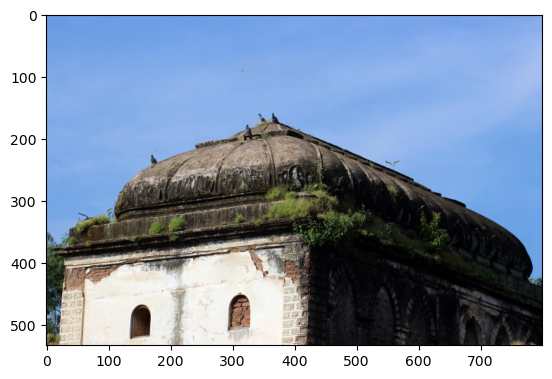

Top 3 most likely landmarks: Gateway of India , Taj Mahal , or Kantanagar Temple


In [24]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()
    print('Top 3 most likely landmarks:',predicted_landmarks[0],',', predicted_landmarks[1],', or', predicted_landmarks[2])
    
    

# test on a sample image
suggest_locations('./landmark_images/test/21.Taj_Mahal/0eb7f9d035f37dbe.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


__Answer:__ The CNN did not provide the right class as the top #1 (correct class = Taj Mahal). However, this is the predicted class top #2, and all the top 3 predicted landmarks are related to temples in India, which indicates the CNN has learned features related to indian building shapes.
Possible improvements: 1) enhance the training dataset with more representative images, 2) utilize a larger area of the images (e.g. 400x400) - much larger computation time though -, and 3) try initializing the network with random weights. 

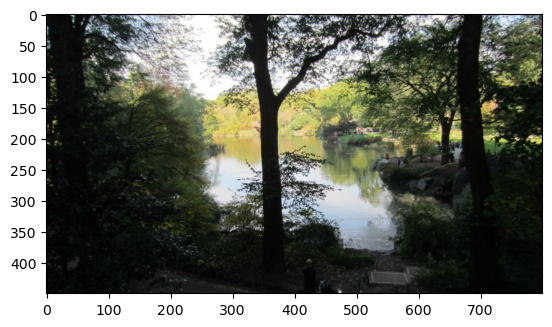

Top 3 most likely landmarks: Central Park , Externsteine , or Yellowstone National Park


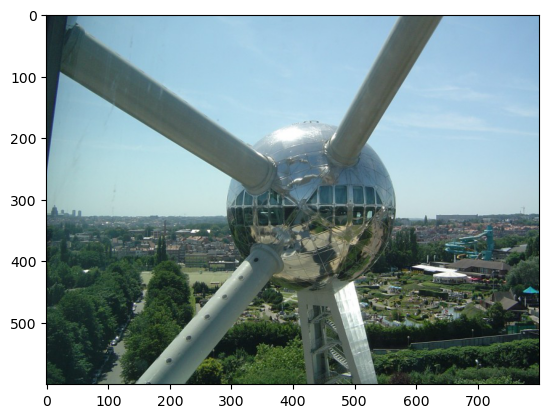

Top 3 most likely landmarks: Atomium , Sydney Harbour Bridge , or Eiffel Tower


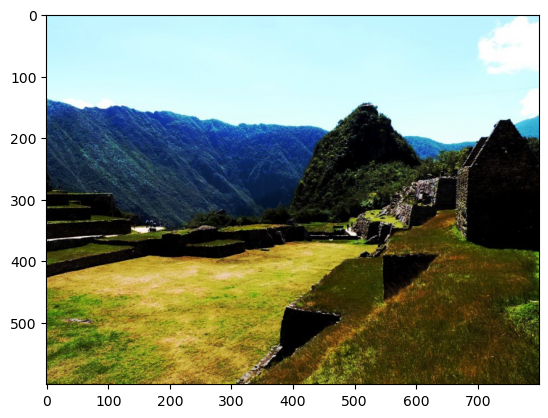

Top 3 most likely landmarks: Machu Picchu , Great Wall of China , or Mount Rainier National Park


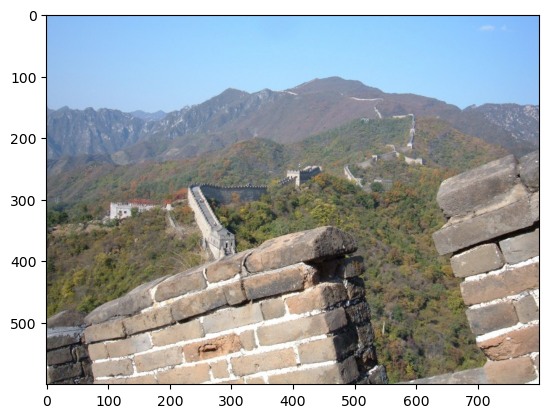

Top 3 most likely landmarks: Machu Picchu , Great Wall of China , or Mount Rainier National Park


In [25]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('./landmark_images/test/15.Central_Park/4d11c274379762de.jpg')
suggest_locations('./landmark_images/test/37.Atomium/69699cd44c59fb31.jpg')
suggest_locations('./landmark_images/test/41.Machu_Picchu/529aeaecb9ba4257.jpg')
suggest_locations('./landmark_images/test/46.Great_Wall_of_China/01a7465354235975.jpg')
